# Hierarchical Clustering

This note introduces the **Hierarchical Clustering** algorithm using `scikit-learn`, explains the step-by-step logic behind how it works, and then demonstrates an intuitive from-scratch-like visualization to show that the core idea is simple and easy to understand.

## What is Hierarchical Clustering?

Hierarchical Clustering is a way of **grouping data step-by-step into a tree-like structure**. Instead of picking a number of clusters upfront (like in K-Means), it builds a hierarchy of clusters either from the bottom up (**agglomerative**) or from the top down (**divisive**).

It works by:
1. Starting with each point as its own cluster
2. Merging the two closest clusters at each step
3. Repeating until everything is merged into a single big cluster

The result is a **dendrogram** — a tree diagram that shows how points are grouped together. By cutting the tree at a certain height, we can choose how many clusters to keep.

This notebook will:
- Use `scikit-learn` to show how Hierarchical Clustering works in practice  
- Explain the intuition and steps in a beginner-friendly way  
- Visualize the clustering as a dendrogram to understand the logic behind it

## Preparation

Let's import the required libraries and create some sample data to work with.

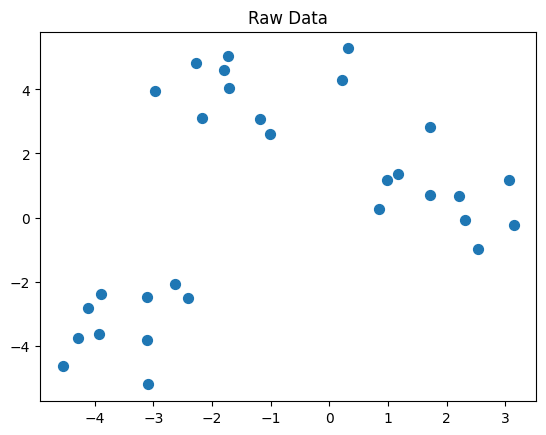

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate synthetic data
X, _ = make_blobs(n_samples=30, centers=3, cluster_std=1.0, center_box=(-5, 5), random_state=42)

# Visualize the raw data
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Raw Data")
plt.show()

## Implement with Scikit-Learn

We'll use `AgglomerativeClustering` from `scikit-learn`, which performs bottom-up (agglomerative) hierarchical clustering.

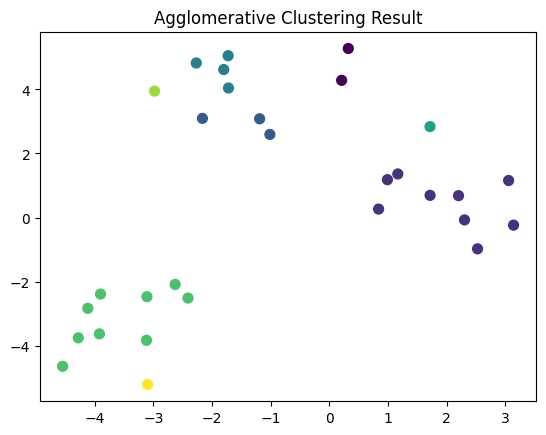

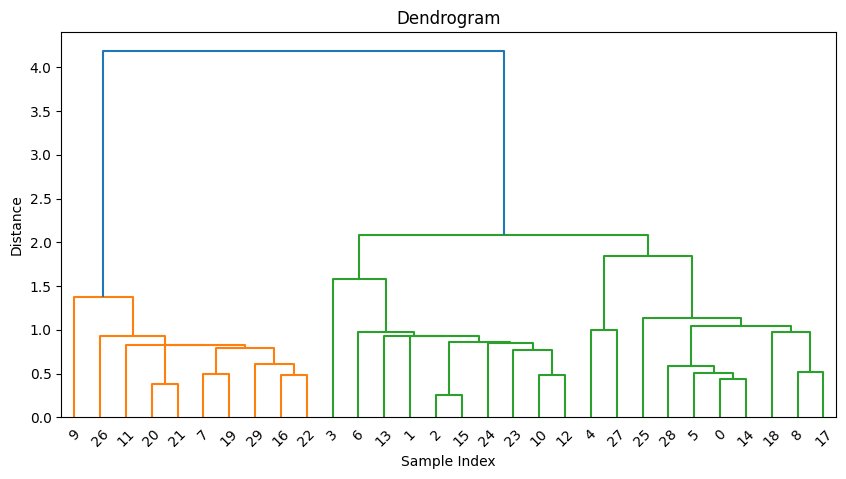

In [ ]:
# Perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=2.0, n_clusters=None, linkage='single')
y_pred = model.fit_predict(X)

# Compute linkage matrix
Z = linkage(X, method='single')

# Plot clustered results
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="viridis", s=50)
plt.title("Agglomerative Clustering Result")
plt.show()

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

## Understanding the Visualization

The diagram above is a **dendrogram**, which shows how clusters are formed step by step in **Agglomerative Clustering**.

Agglomerative Clustering is a **bottom-up approach**:

- Each data point starts as its **own cluster**
- At each step, the two **closest clusters** are merged together
- This continues until **all points are merged** into one big cluster at the top

The **vertical lines** represent merge operations:
- The **height** of each line indicates the **distance (dissimilarity)** between the two clusters being joined
- **Shorter lines** = similar clusters (merged earlier)
- **Taller lines** = more distinct clusters (merged later)

> The dendrogram helps you visualize the nested structure of the data and decide how many clusters to keep by drawing a horizontal line to "cut" the tree. In this example, we could cut it at a certain height to get **2 or 3 clusters**, depending on the structure we want to capture.

While it doesn’t involve iterative training like AdaBoost, **Hierarchical Clustering reveals structure directly from data** — showing not just the final groups, but also the relationships **between clusters at all levels**.

## Behind the Scenes

### How Does Agglomerative Clustering Work?

Unlike K-Means, **you don’t choose the number of clusters upfront**. Instead, you build a **tree of merges**, then decide how many clusters to keep **afterward** by cutting the tree.

Let’s walk through the steps:

### 1. Start with Each Point in Its Own Cluster
- If you have 30 data points, you start with **30 individual clusters**.
- Think of each data point as a small island, all by itself.

### 2. Compute the Distances Between All Clusters
To find out which clusters to merge, we need to measure how **close** they are to each other.

We compute distances between clusters using **linkage methods**:

#### 🧮 Common Linkage Types:
- **Single Linkage**: Distance between the two **closest** points in two clusters  
- **Complete Linkage**: Distance between the two **farthest** points  
- **Average Linkage**: Average distance between **all pairs** of points  
- **Ward’s Method**: Tries to minimize the **total variance** when merging

### 3. Merge the Closest Clusters
- Find the **pair of clusters** with the smallest distance between them.
- **Merge them into one** bigger cluster.
- You now have one fewer cluster than before.

### 4. Repeat Until One Cluster Remains
- Recalculate distances between the new cluster and all others.
- Keep merging the two closest clusters.
- Eventually, all points are merged into one big cluster at the top of the tree.

### 5. Cut the Dendrogram to Get Your Final Clusters

Once the tree is built, you can "cut" it to decide where the clusters end.

There are two common ways to do this:

- **By number of clusters**:  
  Choose how many final groups you want (e.g. 3), and cut the tree so it splits into that many branches.

- **By distance threshold**:  
  Choose a specific height (linkage distance), and keep all clusters that were merged **below** that height.

> You can’t use both at the same time — it's either a fixed number of clusters or a distance-based cutoff. Choose based on whether you care more about the number of clusters or how close points must be to belong together.

## Distance Formula (Euclidean)

To measure how close two points are, we often use **Euclidean distance**:

$$
\text{distance}(x, y) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \cdots + (x_n - y_n)^2}
$$

**Where:**
- $x$ and $y$ are two data points  
- $x_i$ and $y_i$ are values for the $i$‑th feature (like height, width, etc.)

> This formula is used in the linkage step to decide how far apart clusters are.

## Let's Code It

Now we’ll implement **Agglomerative Clustering** (Single Linkage) from scratch using only NumPy.

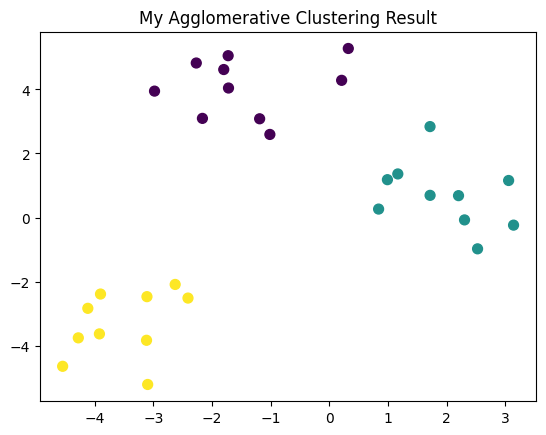

In [ ]:
n = len(X)

# Start with each data point as its own cluster
# For example: [{0}, {1}, {2}, ..., {29}]
clusters = [{i} for i in range(n)]

# This will hold the final cluster assignment for each point
y_pred_my = np.zeros(n, dtype=int)

# Set your custom stopping rule: stop merging when clusters are too far apart
distance_threshold = 2  # You can experiment with this value

# Compute Euclidean distance between two points
def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Compute distance between two clusters (Single Linkage):
# = the shortest distance between any point in c1 and any point in c2
def cluster_distance(c1, c2):
    return min(euclidean(X[i], X[j]) for i in c1 for j in c2)

# Repeat merging until no clusters are close enough
while True:
    min_dist = float('inf')   # Track the smallest distance found in this round
    to_merge = (None, None)   # Store the index of the two clusters to merge

    # Step 2: Find the pair of clusters with the minimum distance
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            # Compute the distance between cluster i and cluster j
            dist = cluster_distance(clusters[i], clusters[j])
            # If this is the smallest distance so far, update our best candidate to merge
            if dist < min_dist:
                min_dist = dist
                to_merge = (i, j)

    # Step 3: Check stopping condition — if the closest pair is too far, stop
    if min_dist > distance_threshold:
        break  # No more merges possible under the threshold

    # Step 4: Merge the closest two clusters
    i, j = to_merge

    # Combine both clusters into one (set union)
    new_cluster = clusters[i].union(clusters[j])

    # Remove the two old clusters and insert the new one
    # ⚠️ Always remove the higher index first to avoid shifting issues
    clusters.pop(j)
    clusters.pop(i)
    clusters.insert(0, new_cluster)

# After all merges are done, we label the remaining clusters (e.g. 0, 1, 2)
# Each data point gets the label of the cluster it belongs to
for label, cluster in enumerate(clusters):
    for idx in cluster:
        y_pred_my[idx] = label

plt.scatter(X[:, 0], X[:, 1], c=y_pred_my, cmap="viridis", s=50)
plt.title("My Agglomerative Clustering Result")
plt.show()

## It Works!!

The clustering result produced by our scratch **Hierarchical (Agglomerative) Clustering** implementation aligns well with the result from `scikit-learn`. This confirms that the core logic we implemented — starting from individual points, computing distances between clusters, and merging the closest pair step by step — behaves as expected.

We've successfully built **Hierarchical Clustering** from the ground up!